In [1]:
!wget https://github.com/opencv/opencv_zoo/raw/master/models/face_detection_yunet/face_detection_yunet_2022mar.onnx
!wget https://i.ibb.co/8MTB6wg/Screenshot-101.png

--2022-12-16 15:41:01--  https://github.com/opencv/opencv_zoo/raw/master/models/face_detection_yunet/face_detection_yunet_2022mar.onnx
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/opencv/opencv_zoo/master/models/face_detection_yunet/face_detection_yunet_2022mar.onnx [following]
--2022-12-16 15:41:02--  https://media.githubusercontent.com/media/opencv/opencv_zoo/master/models/face_detection_yunet/face_detection_yunet_2022mar.onnx
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 345478 (337K) [application/octet-stream]
Saving to: ‘face_detection_yunet_2022mar.onnx.1’

face_detect

In [2]:
import cv2 as cv
import numpy as np
import torch
import scipy
from torchvision import transforms
from google.colab.patches import cv2_imshow
from PIL import Image
from cropp_image import YUNET_CROP
from glass_model import Model

In [62]:
draw_image_function = cv2_imshow

font = cv.FONT_HERSHEY_SIMPLEX
threshold = 0.01
model_name = './model_9 (2).pt'

crop_model = YUNET_CROP(padding = (15,15), 
                        score_threshold = 0.85, 
                        nms_threshold = 0.3)

In [63]:
model = Model(64, arch="resnet18")
model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load(model_name))
model.eval();

def prepare_img(croped_img):
    r, g, b  = Image.fromarray(np.uint8(croped_img)).split()
    return Image.merge('RGB', (b, g, r))

def predict_with_model(model, images):
    if isinstance(images, Image.Image):
        images = [images]
    images = [img.resize((128, 128), Image.LINEAR) for img in images]
    test_transforms = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]),
        ]
    )
    images = torch.stack([test_transforms(img) for img in images], dim=0)
    with torch.no_grad():
        emb, proba = model(images)
    proba = scipy.special.softmax(proba, axis=1)
    return emb.cpu().numpy(), proba.cpu().numpy()


In [64]:
# path_image = "Screenshot_107.png"
# path_image = "img_p.jpg"
# path_image = "kak-podschitat-skolko-lyudej-v-bolshoj-tolpe.jpg"
# path_image = "tagdds_friends-2.jpg"
path_image = "soveti-ludei.jpg"

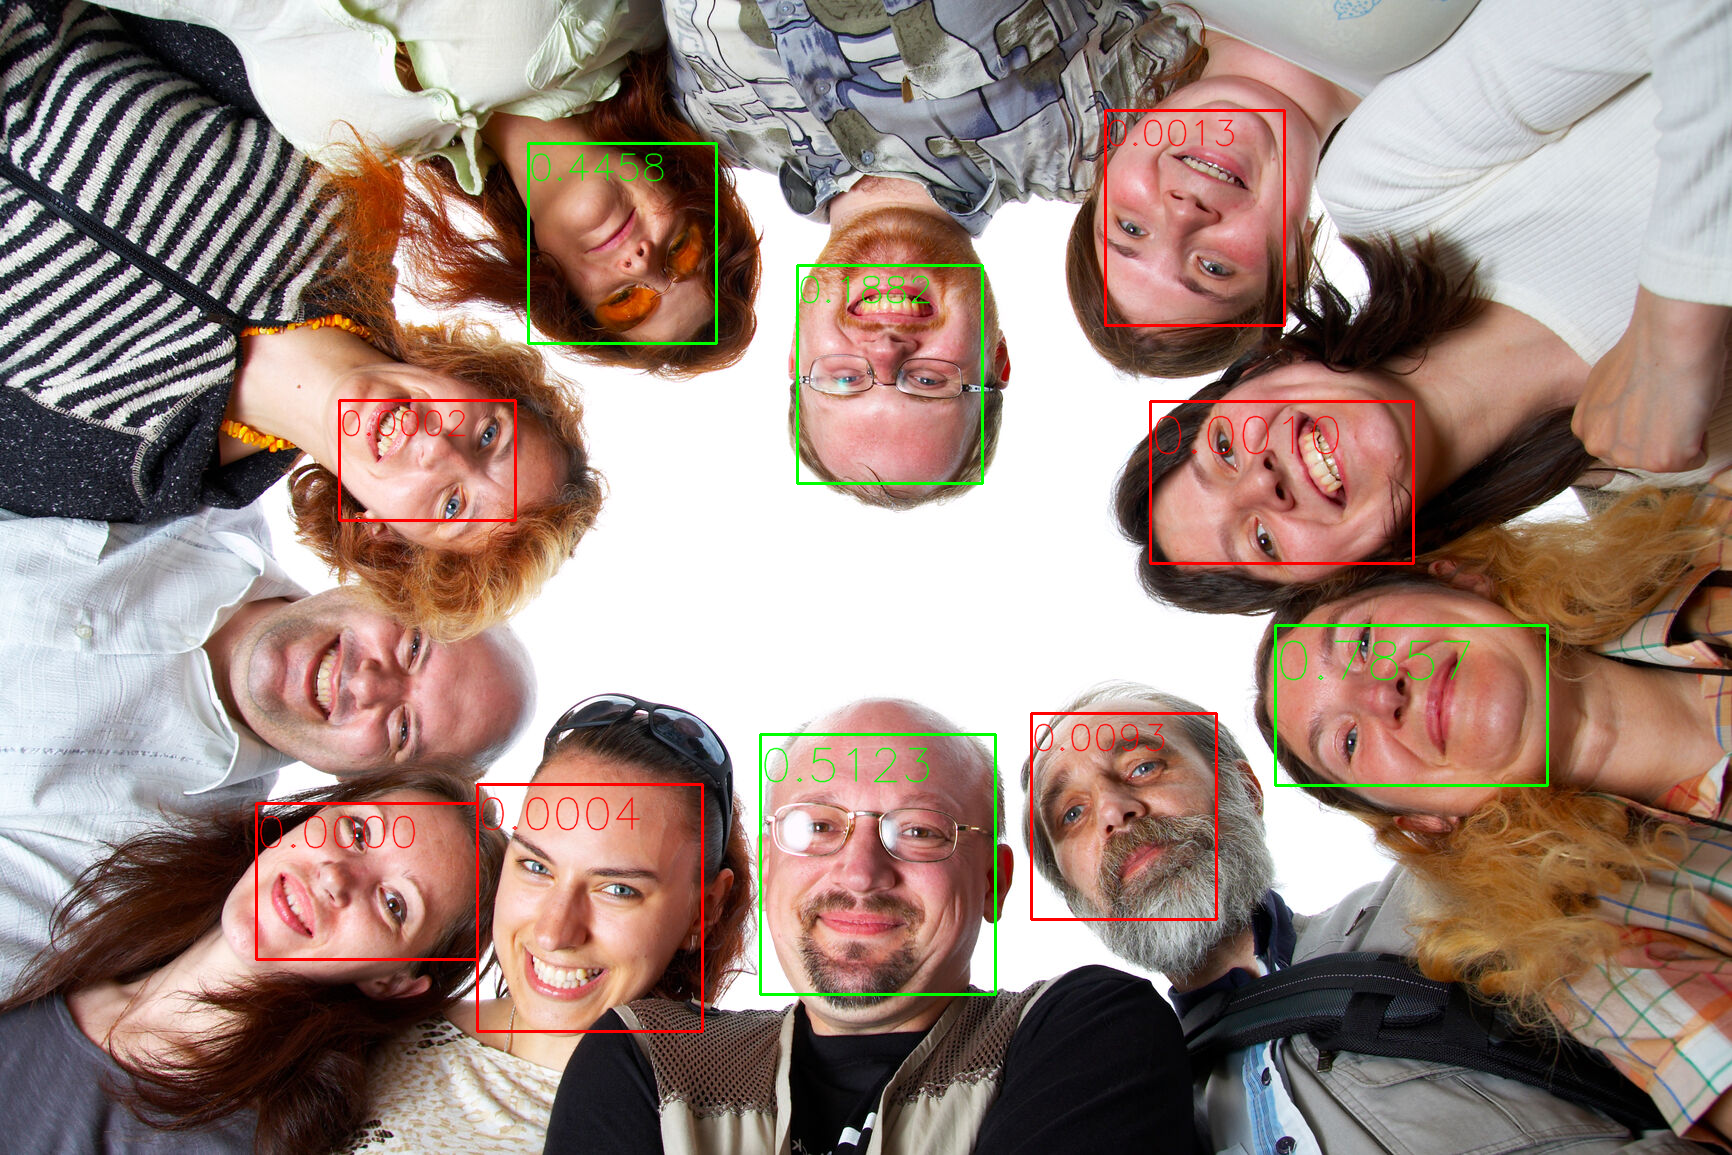

In [65]:
img = cv.imread(path_image)
borders, imgs = crop_model.crop(img)

print_img = img.copy()
if len(borders) > 0:
    _, probas = predict_with_model(model,list(map(prepare_img, imgs)))

    for ccords, proba in zip(borders, probas[:,1]):
        bbox = ccords[0:4].astype(np.int32)

        color = (0,255,0) if proba > threshold else (0,0,255)
        cv.putText(print_img, "{:1.4f}".format(proba) ,(bbox[0], int(bbox[1] + bbox[2] / 5)), 
                font, bbox[2] / 150,color,1,cv.LINE_AA)
        cv.rectangle(print_img, (bbox[0], bbox[1]), (bbox[0]+bbox[2], bbox[1]+bbox[3]), color, 2)
        
    draw_image_function(print_img)

0.51225984


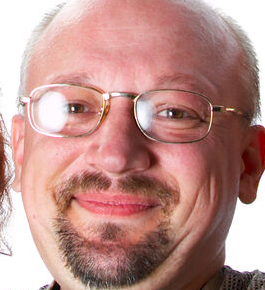

0.00040653002


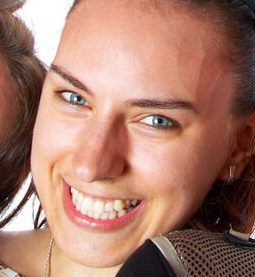

1.1646163e-05


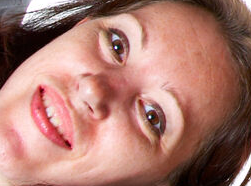

0.009254073


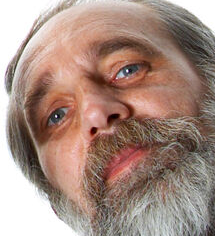

0.44577345


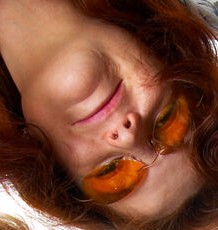

0.0012840223


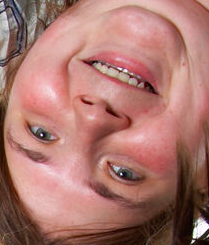

0.18818599


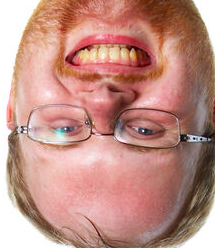

0.0009988347


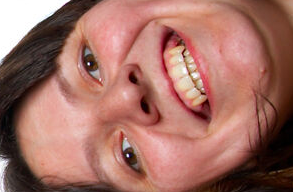

0.7857443


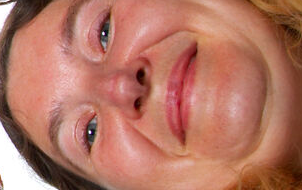

0.00016363368


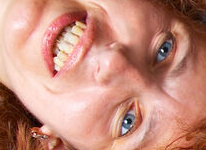

In [66]:
for proba, croped_img in zip(probas[:,1], imgs):
    print(proba)
    # draw_image_function(cv.resize(croped_img, (100, int(croped_img.shape[0] / croped_img.shape[1] * 100))))
    draw_image_function(croped_img)